1RSB cavity equations at Parisi parameter $m=1$
---
We want to solve numerically the following equations:
\begin{align}
	\bar{P}_{\sigma}(th|\bar{th})\mathcal{P}^{RS}(\bar{th}) &= \sum_d\tilde{\Lambda}_d\int \prod_{i=1}^d {\rm d} \mathcal{Q}^{RS}(\bar{tu}_i)\delta[\bar{th}-f(\bar{tu}_1,\dots,\bar{tu}_d,H)]\int\prod_{i=1}^d \bar{Q}_{\sigma}(tu_i|\bar{tu}_i)\delta[th-f(tu_1,\dots,tu_d,H)] \\
	\bar{Q}_{\sigma}(tu|\bar{tu})\mathcal{Q}^{RS}(\bar{tu}) &= \sum_k \tilde{K}_k\sum_s \frac{1}{2} \int \prod_{i=1}^k {\rm d} \mathcal{P}^{RS}(\bar{th}_i)\delta[\bar{tu}-g(\bar{th}_1,\dots,\bar{th}_k,s)] \\
	&\times \sum_{\sigma_1,\dots,\sigma_k}\nu(\sigma_1,\dots,\sigma_k|\bar{h}_1,\dots,\bar{h}_k,s,\sigma)\int \prod_{i=1}^k {\rm d} \bar{P}_{\sigma_i}(th_i|\bar{th}_i)\delta[tu-g(th_1,\dots,th_k,s)] 
\end{align}
where
\begin{align}
	\nu(\sigma_1,\dots,\sigma_k|\bar{th}_1,\dots,\bar{th}_k,s,\sigma) = \frac{\mathbb{I}[\sigma\prod_{i=1}^k\sigma_i=s]\prod_{i=1}^k(1+\sigma_i\bar{th}_i)}{\sum_{\sigma_1,\dots\sigma_d}\mathbb{I}[\sigma\prod_{i=1}^k\sigma_i=s]\prod_{i=1}^k(1+\sigma_i\bar{th}_i)}
\end{align}

Parametrization of the BP equations:
---
The BP equations are written as 
\begin{align}
    m_{ia}(\sigma_i)&=\frac{e^{H\sigma_i}\prod_{b\in\partial i \setminus a}\hat{m}_{bi}(\sigma_i)}{e^{\sigma_i}\prod_{b\in\partial i \setminus a}\hat{m}_{bi}(+)+e^{-H}\prod_{b\in\partial i \setminus a}\hat{m}_{bi}(-)} \\
    \hat{m}_{ai}(\sigma_i)&=\sum_{\{\sigma_j\}_{j\in\partial a \setminus i}}\mathbb{I}\left[\sigma_i\prod_{j\in\partial a\setminus i}\sigma_j=s_a\right]\prod_{j\in\partial a\setminus i}m_{ja}(\sigma_j)
\end{align}
In the equations above we have used the following parametrization:
\begin{align}
    m(\sigma)=\frac{1+\sigma th}{2}, \quad \hat{m}(\sigma)=\frac{1+\sigma tu}{2}
\end{align}
The BP equations are re-written in this parametrization:
\begin{align}
    th=f(tu_1,\dots,tu_d,H)=\frac{e^{H}\prod_{i=1}^k(1+tu_i) - e^{-H}\prod_{i=1}^k(1-tu_i)}{e^{H}\prod_{i=1}^k(1+tu_i) + e^{-H}\prod_{i=1}^k(1-tu_i)}, \quad tu = g(th_1,\dots,th_k,s) = s\prod_{i=1}^k th_i
\end{align}

Numerical implementation
---
In this notebook we use instead the pairs $(m(+),m(-)), (\hat{m}(+), \hat{m}(-))$ to parametrize the BP messages. For instance the distribution $\mathcal{P}^{RS}$ is represented by an array of size 'popsize', each element being a pair (1st element is $m(+)$, 2nd element is $m(-)$.

The joint distribution $\bar{P}_{\sigma}(m|\bar{m})\mathcal{P}^{RS}(\bar{m})$ is represented by the population of couples $(m^{\sigma},\bar{m})$, which is stored as two arrays of size 'popsize'.

In the code below, we thus have a population 'popP' that is a set of 3 arrays indiced from -1 to 1. The array popP[0] corresponds to the distribution $\mathcal{P}^{RS}$. The couple of arrays (popP[-1],popP[0]) corresponds to the distribution $\bar{P}_-(m|\bar{m})\mathcal{P}^{RS}(\bar{m})$ while the couple of arrays (popP[1],popP[0]) corresponds to the distribution $\bar{P}_+(m|\bar{m})\mathcal{P}^{RS}(\bar{m})$

In [1]:
using OffsetArrays

* Two ways of writing the BP functions (one with convolutions)

In [2]:
function BP_th(H, tus)
    p1 = prod(tus[i][1] for i=1:length(tus))*exp(H)
    p2 = prod(tus[i][2] for i=1:length(tus))*exp(-H)
    if p1+p2==0
        println("conflicting messages in BP_th")
    end
    th1 = p1/(p1+p2)
    th2 = p2/(p1+p2)
    (th1, th2)
end

function BP_tu(s, ths)
    tu1=0.0; tu2=0.0
    for sig in Iterators.product(fill(-1:2:1,2)...)
        ind = [(sig[i]==1 ? 1 : 2) for i=1:length(sig)]
        if prod(sig) == s
            tu1 += prod(ths[i][ind[i]] for i=1:length(ths))
        else
            tu2 += prod(ths[i][ind[i]] for i=1:length(ths))
        end
    end
    (tu1, tu2)
end

BP_tu (generic function with 1 method)

In [3]:
conv(h1::Tuple, h2::Tuple) = tuple(h1[1]*h2[1]+h1[2]*h2[2], h1[1]*h2[2]+h1[2]*h2[1]) 
function BP_th_conv(H, tus)
    th = (exp(H), exp(-H))
    for tu in tus
        th = th.*tu
    end
    th ./ sum(th)
end
function BP_tu_conv(s, ths)
   tu = s==1 ? tuple(1.0,0.0) : tuple(0.0,1.0)
   for i in eachindex(ths)
       tu = conv(tu, ths[i]) 
    end
    tu
end

BP_tu_conv (generic function with 1 method)

* Writing the distribution $\nu(\sigma_1,\dots,\sigma_k|\bar{th}_1,\dots,\bar{th}_k,s,\sigma) = \frac{\mathbb{I}[\sigma\prod_{i=1}^k\sigma_i=s]\prod_{i=1}^k m_i(\sigma_i)}{\sum_{\sigma_1,\dots\sigma_d}\mathbb{I}[\sigma\prod_{i=1}^k\sigma_i=s]\prod_{i=1}^k m_i(\sigma_i)}$

In [4]:
function dist_sigmas(s, ths_0, σs, ν)
    k = length(ths_0)
    i = 0
    for sig in Iterators.product(fill(-1:2:1,k)...)
        i += 1
        ind = [(sig[j]==1 ? 1 : 2) for j=1:length(sig)]
        σs[i] = sig
        if prod(sig) == s
            ν[i] += prod(ths_0[j][ind[j]] for j=1:length(ths_0))
        end
    end
    ν ./= sum(ν)
    ν, σs
end

dist_sigmas (generic function with 1 method)

* First we write a function just to iterate the RS cavity equations:
\begin{align}
	\mathcal{P}^{RS}(\bar{th}) &= \sum_d\tilde{\Lambda}_d\int \prod_{i=1}^d {\rm d} \mathcal{Q}^{RS}(\bar{tu}_i)\delta[\bar{th}-f(\bar{tu}_1,\dots,\bar{tu}_d,H)] \\
	\mathcal{Q}^{RS}(\bar{tu}) &= \sum_k \tilde{K}_k\sum_s \frac{1}{2} \int \prod_{i=1}^k {\rm d} \mathcal{P}^{RS}(\bar{th}_i)\delta[\bar{tu}-g(\bar{th}_1,\dots,\bar{th}_k,s)] 
\end{align}
* Once we will obtain a fixed point of this equations, we will use it for the initialization of the 1RSB cavity equations.

In [5]:
using StatsBase, ProgressMeter, Random
residual(x) = (p=OffsetVector((x .* eachindex(x))[1:end], 0:lastindex(x)-1); p./=sum(p))

residual (generic function with 1 method)

In [6]:
function RS(Λ, K, H; 
        maxiter=100, 
        popsize=1000, 
        popP_RS = fill((0.5,0.5), 1:popsize),
        popQ_RS = fill((0.5,0.5), 1:popsize),
        q0 = fill(NaN, 1:maxiter)
    )

    Λ1 = residual(Λ)
    K1 = residual(K)
    wΛ1 = weights(Λ1.parent)#wΛ1 = weights(Λ1)
    wK1 = weights(K1)

    
    @showprogress for t = 1:maxiter
        
        for i = 1:popsize
            k = sample(eachindex(K1), wK1)
            ind_ths = rand(1:popsize, k)
            ths = popP_RS[ind_ths]            
            s = rand((-1,1))
            popQ_RS[i] = BP_tu_conv(s, ths)
        end
        
        q0[t]=0.0
        
        for i = 1:popsize
            d = sample(collect(eachindex(Λ1)), wΛ1)#d = sample(eachindex(Λ1), wΛ1)
            ind_tus = rand(1:popsize, d)
            tus = popQ_RS[ind_tus]
            popP_RS[i] = BP_th_conv(H, tus)
            
            q0[t]+=(popP_RS[i][1]-popP_RS[i][2])^2
        end
        
        q0[t] = q0[t]/length(popP_RS)
    end
    popP_RS, popQ_RS, q0
end

RS (generic function with 1 method)

* Also compute the average RS distorsion:
* On a single instance $O = -E/H = \sum_i\sum_{\sigma_i}b_i(\sigma_i)\sigma_i$ with $b_i(\sigma_i)=\frac{e^{H\sigma_i}\prod_{a\in\partial i}\hat{m}_{ai}(\sigma_i)}{Z_i}$
* the RS Average is $O^{RS} = \sum_{d}\Lambda_d\int\prod_{a=1}^d{\rm d}\mathcal{Q}^{RS}(\hat{m}_a)\sum_{\sigma}\sigma\times\frac{e^{H\sigma}\prod_{a}\hat{m}_{a}(\sigma)}{Z_i}$

In [7]:
function distorsion_RS(Λ, K, H, popP_RS, popQ_RS; 
        maxiter=length(popP_RS) 
    )
    wΛ = weights(Λ)
    popsize = length(popP_RS)

    O = 0.0
    for t = 1:maxiter
        d = sample(eachindex(Λ), wΛ)
        ind_tus = rand(1:popsize, d)
        tus = popQ_RS[ind_tus]
        th = BP_th_conv(H, tus)
        O += th[1]-th[2]
    end
    O =O/maxiter
    (1-O)/2
end

distorsion_RS (generic function with 1 method)

* Computing the quenched RS free energy 

In [8]:
function log_Zi_RS(Λ, H, popQ_RS; 
        maxiter=length(popQ_RS) 
    )
    wΛ = weights(Λ)
    popsize = length(popQ_RS)

    logZ_i = 0.0
    for t = 1:maxiter
        d = sample(eachindex(Λ), wΛ)
        ind_tus = rand(1:popsize, d)
        tus = popQ_RS[ind_tus]
        th = (exp(H), exp(-H))
        for tu in tus
            th = th.*tu
        end
        Z_i = sum(th)
        logZ_i += log(Z_i)
    end
    logZ_i /= maxiter
end

function log_Za_RS(K, popP_RS;
    maxiter=length(popP_RS))
    wK = weights(K)
    popsize = length(popP_RS)
    
    logZ_a = 0.0
    for t=1:maxiter
        k = sample(eachindex(K), wK)
        ind_ths = rand(1:popsize, k)
        ths = popP_RS[ind_ths]
        tu = reduce(conv, ths, init=(1,0))
        Z_a = rand(tu)
        logZ_a += log(Z_a)
    end
    logZ_a /= maxiter
end

function log_Zia_RS(popP_RS, popQ_RS; maxiter=length(popP_RS))
    logZ_ia = 0.0
    for t=1:maxiter
        th = rand(popP_RS)
        tu = rand(popQ_RS)
        Z_ia = sum(th .* tu)
        logZ_ia += log(Z_ia)
    end
    logZ_ia /= maxiter
end


log_Zia_RS (generic function with 1 method)

In [9]:
function F_RS(Λ, K, H, popP_RS, popQ_RS)
    mK = sum(k*K[k] for k=eachindex(K))
    mΛ = sum(d*Λ[d] for d=eachindex(Λ))
    α = mΛ/mK
    F = log_Zi_RS(Λ, H, popQ_RS) + α* log_Za_RS(K, popP_RS) - mΛ*log_Zia_RS(popP_RS, popQ_RS)
end

F_RS (generic function with 1 method)

* Initialization of the populations popP, popQ: 

The array popP[0] representing the RS distribution is filled with the solution of the RS equation.

The arrays popP[$\sigma$] are filled either with $(m_i^{\sigma}(\sigma)=1-\epsilon, m_i^{\sigma}(-\sigma)=\epsilon)$ for each elements i in 1:popsize (function init_pop). This corresponds to set $th^{\sigma}=\sigma\times(1-2\epsilon)$

Or each element m_i of popP[$\sigma$] is set to $m_i(\sigma)=1,m_i(-\sigma)=0)$ with probability $1-\epsilon$, and $m_i=\bar{m}_i$ with probability $\epsilon$ (with $\bar{m}_i$ the i^th element in popP[0]). (function init_pop_alternative)

In [10]:
function init_pop(pop_RS, ϵ)
    N=length(pop_RS)
    pop = fill((NaN, NaN), -1:1, 1:N)
    pop[0,:]=popP_RS
    pop[1,:] =fill( ( 1-ϵ, ϵ), 1:N)
    pop[-1,:] = fill( ( ϵ, 1-ϵ), 1:N)
    pop
end
function init_pop_alternative(pop_RS, ϵ)
    N=length(pop_RS)
    pop = fill((NaN, NaN), -1:1, 1:N)
    pop[0,:]=popP_RS
    for i=1:N
        pop[1,i]=(rand()<ϵ ? pop[0,i] : (1.0, 0.0))
        pop[-1,i]=(rand()<ϵ ? pop[0,i] : (0.0, 1.0))
    end
    pop
end

init_pop_alternative (generic function with 1 method)

* Writing functions to check whether the solution to the 1RSB equations is the RS solution or not:

The trivial RS solution corresponds to have 
\begin{align}
    \bar{P}_{\sigma}(m|\bar{m})\mathcal{P}^{RS}(\bar{m})=\delta(m-\bar{m})\mathcal{P}^{RS}
\end{align}
and similarly for $\bar{Q}_{\sigma}$

The function checkRS computes the quantities $q_0$ and $q_1$ defined in equations (38) of the article by A. Montanari, F. Ricci-Tersenghi and G. Semerjian. Having $q_1-q_0=0$ corresponds to the RS trivial solution, while having $q_1-q_0>0$ corresponds to a non-trivial solution.

In the function checkRS_comparePops we just check on the populations whether we get a delta function (i.e whether for each element $i$ of the population we have $m_i^{\sigma}=\bar{m}_i$)

In [11]:
function checkRS(popP)
    q0=0.0; q1=0.0
    for ind=1:size(popP, 2)
        th = popP[:,ind]
        m0 = th[0][1]-th[0][2]; m1 = th[1][1]-th[1][2]; mm1=th[-1][1]-th[-1][2]
        q0 += m0^2
        q1 += m1*th[0][1] - mm1*th[0][2]
    end
    q1= q1/size(popP, 2); q0=q0/size(popP, 2)
    q0, q1, q1-q0
end

checkRS (generic function with 1 method)

In [12]:
function checkRS_comparePops(popP)
    C1 = [0.0, 0.0]; Cm1=[0.0, 0.0]
    for ind=1:size(popP, 2)
        th = popP[:,ind]
        C1[1] += th[1][1]-th[0][1]
        C1[2] += th[1][2]-th[0][2]
        Cm1[1] += th[-1][1]-th[0][1]
        Cm1[2] += th[-1][2]-th[0][2]
    end
    C1= C1./size(popP, 2); Cm1=Cm1./size(popP, 2)
    C1, Cm1
end

checkRS_comparePops (generic function with 1 method)

* Detect the presence of Hard Fields: 

The function checkHardFields computes how many elements in the population popP[$\sigma$] are hard, i.e are s.t. $m_i^{\sigma}(+)=0$, or s.t. $m_i^{\sigma}(-)=0$ 

In [13]:
function checkHardFields(pop)
    p=(0.0, 0.0)
    for i=1:length(pop)
        p = p .+ (pop[i] .== 0.0)
    end
    p=p./length(pop)
end

checkHardFields (generic function with 1 method)

* Function that iterates the 1RSB cavity equations at $m=1$. It also stores along the iterations the quantities q0, V$=$q1-q0 (defined in equation (38)), as well as p1 and pm1 that corresponds to the proportions of Hard Fields in the population. 

In [14]:
function RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS; 
        maxiter=100, 
        popsize=1000, 
        ϵ=0.01,
        popP = init_pop(popP_RS, ϵ),
        popQ = init_pop(popQ_RS, ϵ),
        q0=fill(0.0, 1:maxiter),
        V=fill(0.0, 1:maxiter),
        p1=fill((0.0, 0.0), 1:maxiter),
        pm1=fill((0.0, 0.0), 1:maxiter)
    )
    
    Λ1 = residual(Λ)
    K1 = residual(K)
    wΛ1 = weights(Λ1.parent)#wΛ1 = weights(Λ1)
    wK1 = weights(K1)
    
    @showprogress for t = 1:maxiter
        for i = 1:popsize
            k = sample(eachindex(K1), wK1)
            ind_ths = rand(1:popsize, k)
            ths = popP[:,ind_ths]            
            s = rand((-1,1))
            popQ[0,i] = BP_tu_conv(s, ths[0,:])
            #@show ind_ths, s
            
            ν = fill(0.0, 1:2^k)
            σs = fill(tuple(fill(NaN, k)...), 1:2^k)
            ν, σs = dist_sigmas(s, ths[0,:], σs, ν)
            wν = weights(ν)
            ind = sample(eachindex(ν), wν)
            σ = convert.(Int64, σs[ind])
            #@show σ
            elts = [ths[s,i] for (i,s) ∈ zip(eachindex(σ), σ)]
            popQ[1,i] = BP_tu_conv(s, elts)

            ν = fill(0.0, 1:2^k)
            σs = fill(tuple(fill(NaN, k)...), 1:2^k)
            ν, σs = dist_sigmas(-s, ths[0,:], σs, ν)
            wν = weights(ν)
            ind = sample(eachindex(ν), wν)
            σ = convert.(Int64, σs[ind])
            #@show σ
            elts = [ths[s,i] for (i,s) ∈ zip(eachindex(σ), σ)]
            popQ[-1,i] = BP_tu_conv(s, elts)
        end

        for i = 1:popsize
            d = sample(collect(eachindex(Λ1)), wΛ1)#d = sample(eachindex(Λ1), wΛ1)
            ind_tus = rand(1:popsize, d)
            tus = popQ[:,ind_tus]
            #@show ind_tus
            popP[0,i] = BP_th_conv(H, tus[0,:])
            popP[-1,i] = BP_th_conv(H, tus[-1,:])
            popP[1,i] = BP_th_conv(H, tus[1,:])
            
            m0 = popP[0,i][1]-popP[0,i][2]; m1 = popP[1,i][1]-popP[1,i][2]; mm1 = popP[-1,i][1]-popP[-1,i][2]
            q0[t]+= m0^2
            V[t]+= m1*popP[0,i][1] - mm1*popP[0,i][2]
            p1[t] = p1[t] .+ (popP[1,i] .== 0.0)
            pm1[t] = pm1[t] .+ (popP[-1,i] .== 0.0)
        end
        
        q0[t] = q0[t]/size(popP, 2)
        V[t] = V[t]/size(popP, 2)
        p1[t] = p1[t]./size(popP, 2)
        pm1[t] = pm1[t]./size(popP, 2)
    end    
    V = V .- q0
    #popP, popQ
    popP, popQ, q0, V, p1, pm1
end

RSB_entropic_m1 (generic function with 1 method)

In [21]:
function av_mag(pop)
    av = 0.0
    for i=1:popsize
        av += abs(pop[i][1]-pop[i][2])
    end
    av /= popsize
end

av_mag (generic function with 1 method)

In [18]:
function prop_small_m(pop, th)
    p1 = mean([pop[i][1]<th for i=1:popsize])
    p2 = mean([pop[i][2]<th for i=1:popsize])
    p1, p2
end

prop_small_m (generic function with 1 method)

Test
---

* First find the fixed point for the RS equations

In [15]:
f3 = 0.2
f1=0.01
f2=1-f1-f3
H=1.6
Λ = OffsetVector([0,f1,1-f3-f1,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
mK = sum(k*K[k] for k=eachindex(K))
mΛ = sum(d*Λ[d] for d=eachindex(Λ))
α = mΛ/mK
R=1-α

0.2699999999999999

In [17]:
popsize = 10^4
maxiter = 2*10^3
q0 = fill(NaN, 1:maxiter)
popP_RS, popQ_RS, q0 = RS(Λ, K, H, maxiter=maxiter, popsize=popsize);
popP_RS

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


10000-element OffsetArray(::Vector{Tuple{Float64, Float64}}, 1:10000) with eltype Tuple{Float64, Float64} with indices 1:10000:
 (0.9999972447635883, 2.7552364117301944e-6)
 (0.011439539750526855, 0.9885604602494732)
 (0.03125894901360666, 0.9687410509863933)
 (0.9989172156197622, 0.0010827843802377873)
 (0.7820963740469881, 0.21790362595301196)
 (0.9998275062434805, 0.0001724937565196136)
 (0.9990001858429581, 0.0009998141570419544)
 (0.647150388129842, 0.352849611870158)
 (0.8785606293788031, 0.12143937062119685)
 (0.9996717098274357, 0.00032829017256428905)
 (0.26349437744027066, 0.7365056225597293)
 (0.8021569119789114, 0.19784308802108866)
 (0.9787636586242735, 0.02123634137572647)
 ⋮
 (0.7500279649143363, 0.24997203508566374)
 (0.8307084443113699, 0.16929155568863005)
 (0.48368271697625315, 0.5163172830237469)
 (0.9946217985115345, 0.005378201488465504)
 (0.9285046075453677, 0.07149539245463235)
 (0.2265738387059645, 0.7734261612940356)
 (0.9759601649834078, 0.024039835016592282)

In [19]:
prop_small_m(popP_RS, 0.00001)

(0.0, 0.0041)

In [22]:
av_mag(popP_RS)

0.8023830466983035

In [23]:
checkHardFields(popP_RS)

(0.0, 0.0)

In [24]:
F_RS(Λ, K, H, popP_RS, popQ_RS)

0.8670741638919095

* Plot the evolution of the intra-state overlap $q_0$ along the iterations

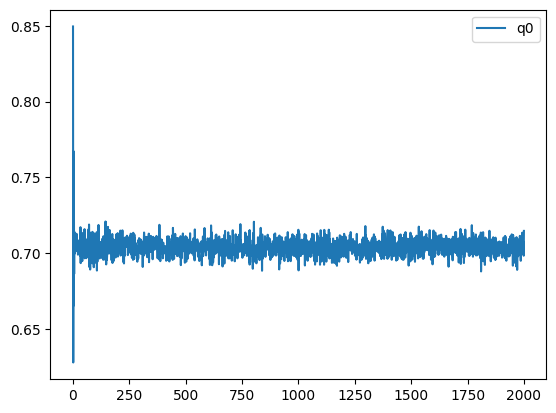

PyObject <matplotlib.legend.Legend object at 0x7f8464069ac8>

In [25]:
using PyPlot
range = 1:maxiter
plot(range, q0[range], label="q0")
legend()

In [26]:
using Statistics
range = 500:1000
meanq0 = mean(q0[range])
stdq0 = std(q0[range])
meanq0, stdq0

(0.7038307175300779, 0.005104855982032934)

In [27]:
distorsion_RS(Λ, K, H, popP_RS, popQ_RS)

0.22236427784348328

* Then find a solution for the 1RSB equations

In [28]:
H, f3, f1

(1.6, 0.2, 0.01)

In [29]:
q0=fill(NaN, 1:maxiter)
V=fill(NaN, 1:maxiter)
p1=fill((NaN, NaN), 1:maxiter)
pm1=fill((NaN, NaN), 1:maxiter)
maxiter=2*10^3
ϵ=0.01
popP, popQ, q0, V, p1, pm1 = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, ϵ=ϵ)
popP

Progress: 100%|█████████████████████████████████████████| Time: 0:06:15


3×10000 OffsetArray(::Matrix{Tuple{Float64, Float64}}, -1:1, 1:10000) with eltype Tuple{Float64, Float64} with indices -1:1×1:10000:
 (0.060593, 0.939407)  (0.58199, 0.41801)  …  (0.998651, 0.00134856)
 (0.060593, 0.939407)  (0.58199, 0.41801)     (0.998651, 0.00134856)
 (0.060593, 0.939407)  (0.58199, 0.41801)     (0.998651, 0.00134856)

In [32]:
popP[-1,:]

10000-element OffsetArray(::Vector{Tuple{Float64, Float64}}, 1:10000) with eltype Tuple{Float64, Float64} with indices 1:10000:
 (0.06059300127709251, 0.9394069987229074)
 (0.5819895138875657, 0.41801048611243424)
 (0.99985239327286, 0.00014760672714000941)
 (0.9998391581886531, 0.00016084181134693178)
 (0.9734433456380289, 0.026556654361971084)
 (0.8547877123131814, 0.14521228768681865)
 (0.9989866841554504, 0.0010133158445496504)
 (0.8905106132106024, 0.10948938678939764)
 (0.34928993774856615, 0.6507100622514338)
 (0.8159377166889861, 0.18406228331101396)
 (0.9920646160787038, 0.007935383921296184)
 (0.7744731070529496, 0.22552689294705033)
 (0.7126575455488492, 0.2873424544511509)
 ⋮
 (0.9480830021574027, 0.05191699784259727)
 (0.9966374521295575, 0.0033625478704425)
 (0.9983835396362767, 0.0016164603637233218)
 (0.9900212958762278, 0.009978704123772277)
 (0.956306450508773, 0.043693549491226814)
 (0.9946868777364493, 0.005313122263550656)
 (0.7194874292855029, 0.28051257071449714)

In [33]:
av_mag(popP[1,:]),  av_mag(popP[-1,:])

(0.7849419908136759, 0.7849419908136759)

In [35]:
prop_small_m(popP[1,:], 10^(-5)),  prop_small_m(popP[-1,:], 10^(-5))

((0.0, 0.0038), (0.0, 0.0038))

In [36]:
popP[1, :]

10000-element OffsetArray(::Vector{Tuple{Float64, Float64}}, 1:10000) with eltype Tuple{Float64, Float64} with indices 1:10000:
 (0.06059300127709251, 0.9394069987229074)
 (0.5819895138875657, 0.41801048611243424)
 (0.99985239327286, 0.00014760672714000941)
 (0.9998391581886531, 0.00016084181134693178)
 (0.9734433456380289, 0.026556654361971084)
 (0.8547877123131814, 0.14521228768681865)
 (0.9989866841554504, 0.0010133158445496504)
 (0.8905106132106024, 0.10948938678939764)
 (0.34928993774856615, 0.6507100622514338)
 (0.8159377166889861, 0.18406228331101396)
 (0.9920646160787038, 0.007935383921296184)
 (0.7744731070529496, 0.22552689294705033)
 (0.7126575455488492, 0.2873424544511509)
 ⋮
 (0.9480830021574027, 0.05191699784259727)
 (0.9966374521295575, 0.0033625478704425)
 (0.9983835396362767, 0.0016164603637233218)
 (0.9900212958762278, 0.009978704123772277)
 (0.956306450508773, 0.043693549491226814)
 (0.9946868777364493, 0.005313122263550656)
 (0.7194874292855029, 0.28051257071449714)

In [37]:
checkHardFields(popP[1,:]), checkHardFields(popP[-1,:]) 

((0.0, 0.0), (0.0, 0.0))

In [38]:
checkRS_comparePops(popP)

([-1.0245791845150953e-18, 4.47311058483622e-19], [-1.0245791845150953e-18, 4.47311058483622e-19])

* Plot the evolution of V, of the proportions of hard fields along the iterations

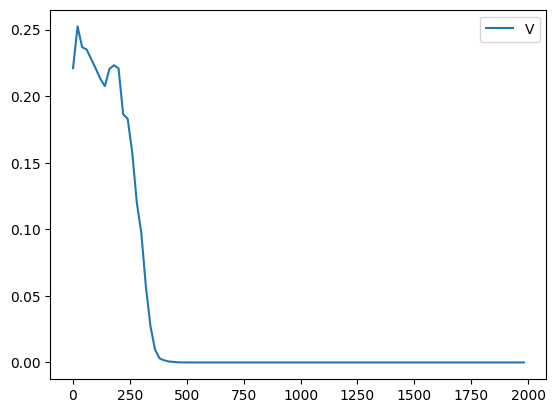

PyObject <matplotlib.legend.Legend object at 0x7f84b4959e10>

In [39]:
using PyPlot
range = 1:20:maxiter
plot(range, V[range], label="V")
legend()

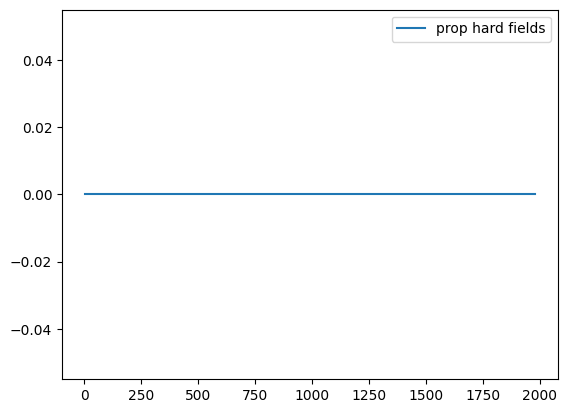

PyObject <matplotlib.legend.Legend object at 0x7f84b4931c18>

In [40]:
range = 1:20:maxiter
plot(range, [p1[i][2] for i=range], label="prop hard fields")
legend()

* Average of V along the iterations

In [41]:
using Statistics
range = 1500:2000
meanV = mean(V[range])
stdV = std(V[range])
meanV, stdV

(1.9057720582387918e-17, 3.4144502645636973e-16)

Test adding some leaves
---

In [86]:
using Unzip
f3 = 0.2
H=1.6
K = OffsetVector([0,0,0,1], 0:3)
mK = sum(k*K[k] for k=eachindex(K))

maxiter=2*10^3
ϵ=0.01
popsize=10^4

f1s = 0.0:0.001:0.01
q0s=fill(NaN, 1:maxiter, eachindex(f1s))
Vs=fill(NaN, 1:maxiter, eachindex(f1s))
p1s=fill((NaN, NaN), 1:maxiter, eachindex(f1s))
pm1s=fill((NaN, NaN), 1:maxiter, eachindex(f1s))
popPs = fill((NaN, NaN), -1:1, 1:popsize, eachindex(f1s))
popQs = fill((NaN, NaN), -1:1, 1:popsize, eachindex(f1s))


for (i,f1) in pairs(f1s)
    Λ = OffsetVector([0,f1,1-f3-f1,f3], 0:3)
    mΛ = sum(d*Λ[d] for d=eachindex(Λ))
    α = mΛ/mK
    R=1-α
    popP_RS, popQ_RS = RS(Λ, K, H, maxiter=maxiter, popsize=popsize);
    popP, popQ, q0s[:,i], Vs[:,i], p1s[:,i], pm1s[:,i] = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, ϵ=ϵ)
    @show f1, R, Vs[maxiter,i], p1s[maxiter,i]
    popPs[:,:,i]=popP; popQs[:,:,i]=popQ 
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:05:55


(f1, R, Vs[maxiter, i], p1s[maxiter, i]) = (0.0, 0.2666666666666666, 0.2950605420075104, (0.0, 0.0001))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:49


(f1, R, Vs[maxiter, i], p1s[maxiter, i]) = (0.001, 0.267, 0.29833817195435575, (0.0, 0.0))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:51


(f1, R, Vs[maxiter, i], p1s[maxiter, i]) = (0.002, 0.2673333333333332, 0.28426481268657056, (0.0, 0.0))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:47


(f1, R, Vs[maxiter, i], p1s[maxiter, i]) = (0.003, 0.2676666666666666, 0.2815423603141397, (0.0, 0.0))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:52


(f1, R, Vs[maxiter, i], p1s[maxiter, i]) = (0.004, 0.2679999999999999, 0.26488753903980555, (0.0, 0.0))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:47


(f1, R, Vs[maxiter, i], p1s[maxiter, i]) = (0.005, 0.2683333333333332, 0.24214360940874757, (0.0, 0.0))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:55


(f1, R, Vs[maxiter, i], p1s[maxiter, i]) = (0.006, 0.2686666666666667, 0.0, (0.0, 0.0))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:53


(f1, R, Vs[maxiter, i], p1s[maxiter, i]) = (0.007, 0.269, 0.0, (0.0, 0.0))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:47


(f1, R, Vs[maxiter, i], p1s[maxiter, i]) = (0.008, 0.2693333333333333, 0.0, (0.0, 0.0))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:56


(f1, R, Vs[maxiter, i], p1s[maxiter, i]) = (0.009, 0.2696666666666667, 0.0, (0.0, 0.0))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:48


(f1, R, Vs[maxiter, i], p1s[maxiter, i]) = (0.01, 0.2699999999999999, 0.0, (0.0, 0.0))


In [87]:
avmag_popPs = fill(NaN, -1:1, eachindex(f1s))
for j=-1:1
    avmag_popPs[j,:] = [av_mag(popPs[j,:,i]) for i in eachindex(f1s)]
end
avmag_popPs

3×11 OffsetArray(::Matrix{Float64}, -1:1, 1:11) with eltype Float64 with indices -1:1×1:11:
 1.0       0.974512  0.933651  0.910506  …  0.797548  0.799443  0.798877
 0.792474  0.790076  0.793609  0.792356     0.797548  0.799443  0.798877
 1.0       0.998539  0.991552  0.989548     0.797548  0.799443  0.798877

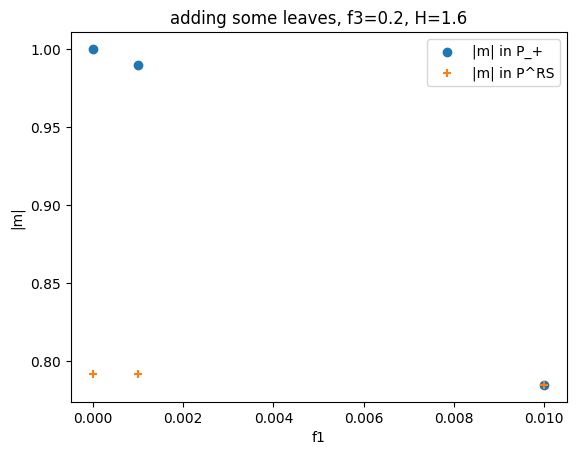

PyObject <matplotlib.legend.Legend object at 0x7f845f3c8048>

In [79]:
xlabel("f1")
ylabel("|m|")
title("adding some leaves, f3=0.2, H=1.6")
scatter(f1s, [avmag_popPs[1,i] for i=[1,3,4]], label="|m| in P_+")
scatter([f1s[i] for i=[1,3,4]], [avmag_popPs[0,i] for i=[1,3,4]], marker="+", label="|m| in P^RS")
legend()

In [80]:
prop_small_m(popPs[1,:,3], 10^(-15)), f1s[3]

((0.0, 0.0642), 0.001)

In [81]:
[popPs[1,i,3][2] for i=1:popsize]

10000-element Vector{Float64}:
 2.3262747448791806e-15
 8.305919149496028e-14
 1.0968816208032332e-13
 5.56882124982198e-13
 2.177676604226086e-10
 7.296124889362848e-5
 1.9470414592102832e-8
 0.006557308921464356
 9.685994085914733e-8
 9.815497123256535e-9
 5.391509390721929e-10
 5.1360606522068717e-8
 8.314069157398948e-6
 ⋮
 4.5269848729321055e-8
 1.343222611168171e-10
 1.3467745098564458e-22
 7.485253118067801e-11
 3.823920390882148e-12
 7.073943297844807e-5
 6.081627170115876e-9
 2.7015944094893615e-6
 0.0008289620233632367
 1.5516574110196171e-16
 1.0813471240506895e-12
 7.262659964887126e-8

In [84]:
bins = [0.0, 10^(-20), 10^(-5), 0.1, 1.0]
fit(Histogram, [popPs[1,i,3][2] for i=1:popsize], bins)

Histogram{Int64, 1, Tuple{Vector{Float64}}}
edges:
  [0.0, 1.0000000000000011e-20, 1.0000000000000003e-5, 0.1, 1.0]
weights: [97, 8005, 1792, 106]
closed: left
isdensity: false

Test at $f_3=0.2$
---

In [30]:
using Unzip
f3 = 0.2
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
mK = sum(k*K[k] for k=eachindex(K))
mΛ = sum(d*Λ[d] for d=eachindex(Λ))
α = mΛ/mK
R=1-α

maxiter=2*10^3
ϵ=0.01
popsize=10^4

Hs = 1.0:0.1:2.0
q0s=fill(NaN, 1:maxiter, eachindex(Hs))
Vs=fill(NaN, 1:maxiter, eachindex(Hs))
p1s=fill((NaN, NaN), 1:maxiter, eachindex(Hs))
pm1s=fill((NaN, NaN), 1:maxiter, eachindex(Hs))
popPs = fill((NaN, NaN), -1:1, 1:popsize, eachindex(Hs))
popQs = fill((NaN, NaN), -1:1, 1:popsize, eachindex(Hs))


for (i,H) in pairs(Hs)
    popP_RS, popQ_RS = RS(Λ, K, H, maxiter=maxiter, popsize=popsize);
    popP, popQ, q0s[:,i], Vs[:,i], p1s[:,i], pm1s[:,i] = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, ϵ=ϵ)
    @show H, Vs[maxiter,i], p1s[maxiter,i], distorsion_RS(Λ, K, H, popP_RS, popQ_RS)
    popPs[:,:,i]=popP; popQs[:,:,i]=popQ 
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:53


(H, Vs[maxiter, i], p1s[maxiter, i]) = (1.0, 1.1102230246251565e-16, (0.0, 0.0))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:13


(H, Vs[maxiter, i], p1s[maxiter, i]) = (1.1, 0.0, (0.0, 0.0))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:05:12


(H, Vs[maxiter, i], p1s[maxiter, i]) = (1.2, 0.0, (0.0, 0.0))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:12


(H, Vs[maxiter, i], p1s[maxiter, i]) = (1.3, 0.0, (0.0, 0.0))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:12


(H, Vs[maxiter, i], p1s[maxiter, i]) = (1.4, 0.0, (0.0, 0.0))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:09


(H, Vs[maxiter, i], p1s[maxiter, i]) = (1.5, 0.3077846469797232, (0.0, 0.0))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:05:11


(H, Vs[maxiter, i], p1s[maxiter, i]) = (1.6, 0.29503639898246026, (0.0, 0.0008))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:08


(H, Vs[maxiter, i], p1s[maxiter, i]) = (1.7, 0.27275487967673495, (0.0, 0.0084))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:04


(H, Vs[maxiter, i], p1s[maxiter, i]) = (1.8, 0.26415245986319147, (0.0, 0.0689))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:09


(H, Vs[maxiter, i], p1s[maxiter, i]) = (1.9, 0.25300537899037223, (0.0, 0.084))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:05:13


(H, Vs[maxiter, i], p1s[maxiter, i]) = (2.0, 0.23612419103945526, (0.0, 0.1913))


In [155]:
Hs[6]

1.5

In [157]:
popPs[1,:,6]

10000-element OffsetArray(::Array{Tuple{Float64,Float64},1}, 1:10000) with eltype Tuple{Float64,Float64} with indices 1:10000:
 (1.0, 1.8797689920287923e-49)
 (1.0, 1.87996967606022e-49)
 (1.0, 2.152980804426758e-49)
 (1.0, 1.8768576419922893e-57)
 (1.0, 1.4514088271509315e-54)
 (1.0, 4.159713878873278e-54)
 (1.0, 1.8373904219400205e-56)
 (1.0, 4.5689071757858616e-102)
 (1.0, 7.202934467098164e-55)
 (1.0, 5.245187096244897e-51)
 (1.0, 2.5147525782266185e-54)
 (1.0, 3.587836369122319e-56)
 (1.0, 2.9074337386256804e-53)
 ⋮
 (1.0, 7.577022683601516e-55)
 (1.0, 7.352902955494224e-52)
 (1.0, 2.7710004951022235e-104)
 (1.0, 4.81254255900279e-52)
 (1.0, 1.090783187811014e-56)
 (1.0, 2.5878071110262998e-48)
 (1.0, 9.733207292990346e-158)
 (1.0, 1.1095758744048342e-49)
 (1.0, 9.462907843164574e-57)
 (1.0, 2.903234137480433e-52)
 (1.0, 4.463839172236132e-105)
 (1.0, 4.696804574370163e-52)

In [161]:
minimum([popPs[1,i,6][2] for i=1:popsize])

3.6205065205812163e-261

In [196]:
maximum([popPs[1,i,6][2] for i=1:popsize])

2.0185585490322663e-44

In [148]:
avmag_popPs = fill(NaN, -1:1, eachindex(Hs))
for j=-1:1
    avmag_popPs[j,:] = [av_mag(popPs[j,:,i]) for i in eachindex(Hs)]
end
avmag_popPs

3×11 OffsetArray(::Array{Float64,2}, -1:1, 1:11) with eltype Float64 with indices -1:1×1:11:
 0.671353  0.709556  0.732081  0.74645  …  1.0       1.0       1.0
 0.671353  0.709556  0.732081  0.74645     0.813996  0.822602  0.835088
 0.671353  0.709556  0.732081  0.74645     1.0       1.0       1.0

In [217]:
avmag_popPs[0,:]

11-element OffsetArray(::Array{Float64,1}, 1:11) with eltype Float64 with indices 1:11:
 0.6713528667488403
 0.7095557422817419
 0.7320809960516829
 0.7464503418478543
 0.7609164586678767
 0.7859562196624175
 0.794744735161962
 0.8109112227311625
 0.8139962568417576
 0.8226021390331424
 0.8350879784700089

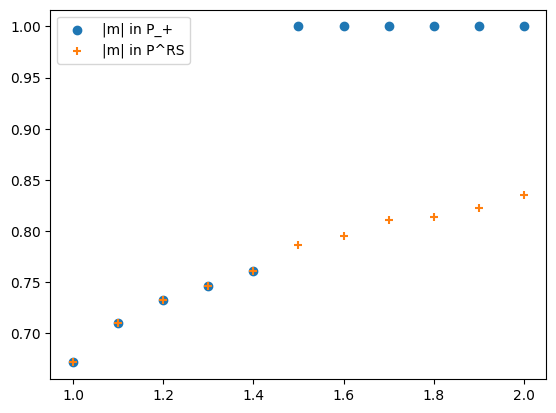

PyObject <matplotlib.legend.Legend object at 0x7fe9cd688c18>

In [153]:
scatter(Hs, avmag_popPs[1,:], label="|m| in P_+")
scatter(Hs, avmag_popPs[0,:], marker="+", label="|m| in P^RS")
legend()

In [207]:
#fraction of fields such that m(+)>0.999 in P_-, P^RS, P_+
prop_largem1 = fill(NaN, -1:1, eachindex(Hs))
for j=-1:1
    for k in eachindex(Hs)
        prop_largem1[j,k] = mean([popPs[j,i,k][1]>0.999 for i=1:popsize])
    end
end
prop_largem1

3×11 OffsetArray(::Array{Float64,2}, -1:1, 1:11) with eltype Float64 with indices -1:1×1:11:
 0.0029  0.008  0.0195  0.0294  0.0498  …  0.0     0.0     0.0     0.0
 0.0029  0.008  0.0195  0.0294  0.0498     0.1334  0.1749  0.1917  0.2157
 0.0029  0.008  0.0195  0.0294  0.0498     1.0     1.0     1.0     1.0

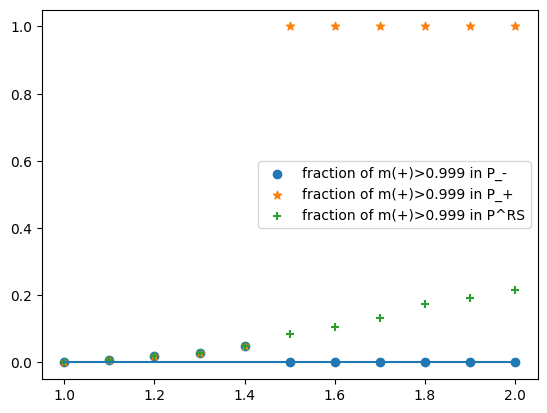

PyObject <matplotlib.legend.Legend object at 0x7fe9cd4ebe80>

In [212]:
scatter(Hs, prop_largem1[-1,:], label="fraction of m(+)>0.999 in P_-")
scatter(Hs, prop_largem1[1,:], marker="*", label="fraction of m(+)>0.999 in P_+")
scatter(Hs, prop_largem1[0,:], marker="+", label="fraction of m(+)>0.999 in P^RS")
plot((1.0,2.0), (0.0,0.0))
legend()

In [208]:
#fraction of fields such that m(-)>0.999 in P_-, P^RS, P_+
prop_largem2 = fill(NaN, -1:1, eachindex(Hs))
for j=-1:1
    for k in eachindex(Hs)
        prop_largem2[j,k] = mean([popPs[j,i,k][2]>0.999 for i=1:popsize])
    end
end
prop_largem2

3×11 OffsetArray(::Array{Float64,2}, -1:1, 1:11) with eltype Float64 with indices -1:1×1:11:
 0.0  0.0  0.0  0.0003  0.0001  1.0     1.0    1.0    1.0     1.0     1.0
 0.0  0.0  0.0  0.0003  0.0001  0.0005  0.001  0.001  0.0023  0.0018  0.0042
 0.0  0.0  0.0  0.0003  0.0001  0.0     0.0    0.0    0.0     0.0     0.0

In [123]:
using JLD
save("data_f0p2.jld", "Hs", Hs)
save("data_f0p2.jld", "q0s", q0s)
save("data_f0p2.jld", "Vs", Vs)
save("data_f0p2.jld", "p1s", p1s)
save("data_f0p2.jld", "pm1s", pm1s)
save("data_f0p2.jld", "popPs", popPs)

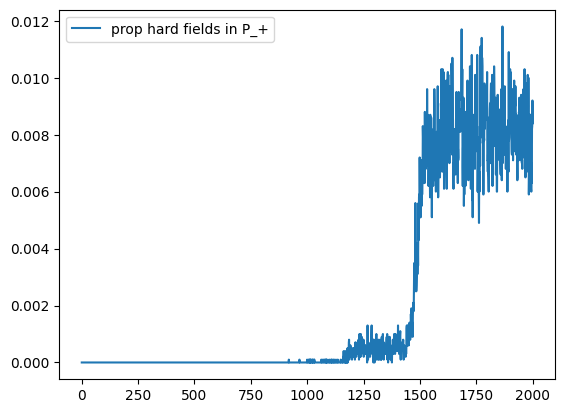

PyObject <matplotlib.legend.Legend object at 0x7fe9cd3c9f28>

In [215]:
i=8
range = 1:1:2000
#plot(range, q0s[range, i], label="q0")
#plot(range, Vs[range, i], label="V=q1-q0")
plot(range, [p1s[j,i][2] for j=range], label="prop hard fields in P_+")
legend()

In [53]:
using Statistics
q0_mean = mean.(q0s[1000:2000, i] for i=1:11) 
q0_std = std.(q0s[1000:2000,i] for i=1:11)
V_mean = mean.(Vs[1000:2000, i] for i=1:11) 
V_std = std.(Vs[1000:2000,i] for i=1:11)
V_mean, V_std

([1.4418480839287748e-18, 1.109113910714442e-19, -1.4418480839287748e-18, -1.1091139107144421e-18, 4.769189816072101e-18, 0.31520933036975357, 0.29607345775317373, 0.27901110156946846, 0.2642729264995084, 0.25077901498868843, 0.23865992392128893], [6.443418890023652e-17, 7.100212608640688e-17, 7.287251988078034e-17, 7.228396871567443e-17, 7.669004447019368e-17, 0.005549520049075774, 0.005140340607933536, 0.005369323453200413, 0.00511462999795579, 0.004986162227923241, 0.005198317063023581])

* Retry but with a larger population size

In [36]:
using Unzip
f3 = 0.2
Λ = [0,1-f3,f3]
K = [0,0,1]
mK = sum(k*K[k] for k=eachindex(K))
mΛ = sum(d*Λ[d] for d=eachindex(Λ))
α = mΛ/mK
R=1-α

maxiter=2*10^3
ϵ=0.01
popsize=10^5

Hs_pop1e5 = 1.4:0.1:1.7
q0s_pop1e5=fill(NaN, 1:maxiter, eachindex(Hs_pop1e5))
Vs_pop1e5=fill(NaN, 1:maxiter, eachindex(Hs_pop1e5))
p1s_pop1e5=fill((NaN, NaN), 1:maxiter, eachindex(Hs_pop1e5))
pm1s_pop1e5=fill((NaN, NaN), 1:maxiter, eachindex(Hs_pop1e5))
popPs_pop1e5 = fill((NaN, NaN), -1:1, 1:popsize, eachindex(Hs_pop1e5))
popQs_pop1e5 = fill((NaN, NaN), -1:1, 1:popsize, eachindex(Hs_pop1e5))


for (i,H) in pairs(Hs_pop1e5)
    popP_RS, popQ_RS = RS(Λ, K, H, maxiter=maxiter, popsize=popsize);
    popP, popQ, q0s_pop1e5[:,i], Vs_pop1e5[:,i], p1s_pop1e5[:,i], pm1s_pop1e5[:,i] = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, ϵ=ϵ)
    @show H, Vs_pop1e5[maxiter,i], p1s_pop1e5[maxiter,i]
    popPs_pop1e5[:,:,i]=popP; popQs_pop1e5[:,:,i]=popQ 
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:42
Progress: 100%|█████████████████████████████████████████| Time: 1:06:55


(H, Vs_pop1e5[maxiter, i], p1s_pop1e5[maxiter, i]) = (1.4, -1.1102230246251565e-16, (0.0, 0.0))


Progress: 100%|█████████████████████████████████████████| Time: 0:01:19
Progress: 100%|█████████████████████████████████████████| Time: 1:02:12


(H, Vs_pop1e5[maxiter, i], p1s_pop1e5[maxiter, i]) = (1.5, 0.31694144064740726, (0.0, 0.0))


Progress: 100%|█████████████████████████████████████████| Time: 0:01:32
Progress: 100%|█████████████████████████████████████████| Time: 0:53:14


(H, Vs_pop1e5[maxiter, i], p1s_pop1e5[maxiter, i]) = (1.6, 0.296552363874628, (0.0, 0.0))


Progress: 100%|█████████████████████████████████████████| Time: 0:01:33
Progress: 100%|█████████████████████████████████████████| Time: 0:50:25


(H, Vs_pop1e5[maxiter, i], p1s_pop1e5[maxiter, i]) = (1.7, 0.2797597528567297, (0.0, 0.00062))


In [124]:
using JLD
save("data_f0p2_pop1e5.jld", "Hs_pop1e5", Hs_pop1e5)
save("data_f0p2_pop1e5.jld", "q0s_pop1e5", q0s_pop1e5)
save("data_f0p2_pop1e5.jld", "Vs_pop1e5", Vs_pop1e5)
save("data_f0p2_pop1e5.jld", "p1s_pop1e5", p1s_pop1e5)
save("data_f0p2_pop1e5.jld", "pm1s_pop1e5", pm1s_pop1e5)
save("data_f0p2_pop1e5.jld", "popPs_pop1e5", popPs_pop1e5)

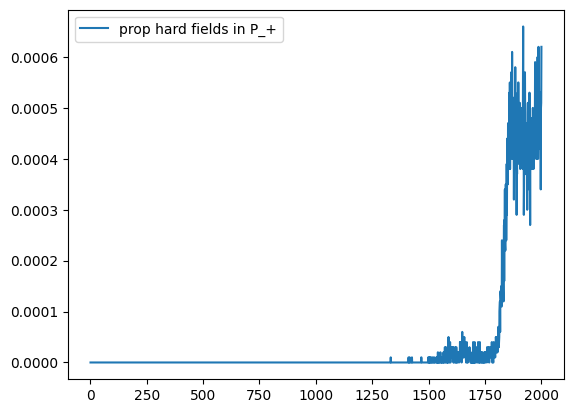

PyObject <matplotlib.legend.Legend object at 0x7fe9cd33ea90>

In [216]:
i=4
range = 1:1:2000
#plot(range, q0s_pop1e5[range, i], label="q0")
#plot(range, Vs_pop1e5[range, i], label="V=q1-q0")
plot(range, [p1s_pop1e5[j,i][2] for j=range], label="prop hard fields in P_+")
legend()

In [169]:
Hs_pop1e5[3]

1.6

In [176]:
minimum([popPs_pop1e5[1,i,2][2] for i=1:popsize])

7.32942452362441e-131

In [178]:
mean([popPs_pop1e5[1,i,3][2] for i=1:popsize])

2.4871514875531567e-45

In [55]:
using Statistics
q0_mean_pop1e5 = mean.(q0s_pop1e5[1000:2000, i] for i=1:4) 
q0_std_pop1e5 = std.(q0s_pop1e5[1000:2000,i] for i=1:4)
V_mean_pop1e5 = mean.(Vs_pop1e5[1000:2000, i] for i=1:4) 
V_std_pop1e5 = std.(Vs_pop1e5[1000:2000,i] for i=1:4)
V_mean_pop1e5, V_std_pop1e5

([-2.5509619946432167e-18, 0.31526475883889316, 0.2961136803811652, 0.27916770854375705], [7.932242668765756e-17, 0.0016037880747274622, 0.001578457684200754, 0.0017395377875712077])

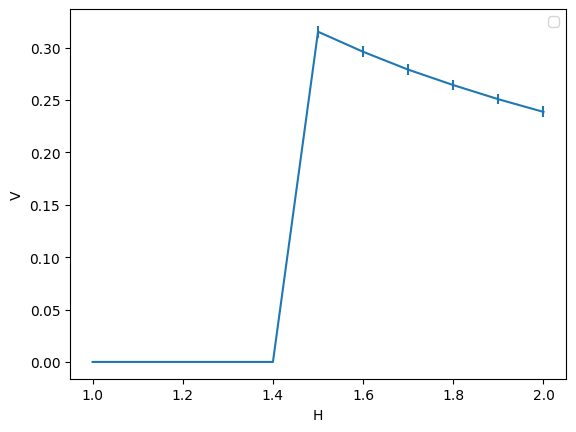

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7fe9ce2e5ef0>

In [118]:
using PyPlot
xlabel("H")
ylabel("V")
errorbar(Hs, V_mean, yerr=V_std)
#errorbar(Hs_pop1e5, V_mean_pop1e5, yerr=V_std_pop1e5)
legend()